In [1]:
# on colab run this cell to install the required packages
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00


In [2]:
import torch
from transformers import DistilBertForMaskedLM
from transformers import DistilBertTokenizer
from transformers import CamembertTokenizerFast, CamembertForMaskedLM
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# en
# model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# fr
model = CamembertForMaskedLM.from_pretrained("camembert-base")
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

In [14]:
def create_maskedSentences(text):
    masked_sentences = []
    inputs = tokenizer(text, return_tensors="pt")
    n_tokens = inputs["input_ids"].shape[1]
    for i in range(1, n_tokens-1):
        s = tokenizer(text, return_tensors="pt")
        s["labels"] = s["input_ids"].detach().clone()
        t = torch.zeros(n_tokens, dtype=torch.bool)
        t[i] = True
        s["input_ids"][0,i] = 103  # MASK token
        masked_sentences.append({"inputs": s, "mask": t, "id_masked": i})
    return masked_sentences

def print_inputs(inputs):
    return " ".join(list(map(tokenizer.convert_ids_to_tokens, inputs["input_ids"]))[0])

def parse_sentences(sentences):
    """_summary_

    Args:
        sentences (list): list of dict containing keys : 
            - 'inputs' : transformers.tokenization_utils_base.BatchEncoding with 'input_ids', 'attention_mask' and 'labels'. One of the tokens in input_ids is a MASK token (103)
            - 'id_masked' : index of the masked word
    """
    for sentence in sentences:
        inputs = sentence["inputs"]
        loss, logits = model(**inputs).values()
        score_surprise = ((logits[:, sentence["id_masked"], :].argsort(descending=True) == sentence["inputs"]["labels"][0,sentence["id_masked"]]).flatten()).nonzero()[0,0].item()
        sentence["score_surprise"] = score_surprise
        
def plot_barSurprise(sentences):
    """_summary_

    Args:
        sentences (list): list of dict containing keys : 
            - 'inputs' : transformers.tokenization_utils_base.BatchEncoding with 'input_ids', 'attention_mask' and 'labels'. One of the tokens in input_ids is a MASK token (103)
            - 'id_masked' : index of the masked word
            - 'score_surprise' (float): high value = big surprise
    """
    scores = [x["score_surprise"] for x in sentences]
    words = list(map(tokenizer.convert_ids_to_tokens, sentences[0]["inputs"]["labels"]))[0][1:-1]
    plt.bar(words, scores)
    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max(t.get_window_extent().width for t in tl)
    m = 1 # inch margin
    s = maxsize/plt.gcf().dpi*len(words)+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
    
def highlight_text(sentences, lamb = 0.01):
    """_summary_

    Args:
        sentences (_type_): _description_
        lamb (float, optional): _description_. Defaults to 0.01.
    """
    scores = [x["score_surprise"] for x in sentences]
    words = list(map(tokenizer.convert_ids_to_tokens, sentences[0]["inputs"]["labels"]))[0][1:-1]
    fig, ax = plt.subplots()
    fig.set_size_inches((10,6))
    plt.axis('off')
    offset_y = 0.1
    offset_x = 0.01
    for i in range(len(words)):
        t = plt.text(offset_x + (i%10)/10,1-offset_y-(i//10)/10,words[i])
        t.set_bbox(dict(facecolor='red', alpha=1-np.exp(-scores[i]*lamb)))
        plt.text(offset_x + 0.01 + (i%10)/10,1-offset_y-0.045-(i//10)/10,scores[i], fontdict={"fontsize":7})

In [6]:
# en 
# text = "Peter is brave and never gives up. He has the heart of a lion."
# text = "Since I started this new job I am always looking forward to meet new people. I am open to all opportunities. It is like I am always searching for my next prey"
# text0 = "My lawyer has been my trusted ally, guiding me through the intricate labyrinth of the legal system."
# text1 = "My lawyer has been my trusted ally, guiding me through the intricate labyrinth of the legal system. He is a shark."
# text2 = "My lawyer has been my trusted ally, guiding me through the intricate labyrinth of the legal system. He is searching for his next prey."
# text3 = "My lawyer has been my trusted ally, guiding me through the intricate labyrinth of the legal system. He is a shark searching for his next prey."


# fr
text_baudelaire_soleil = "Les soleils mouillés de ces ciels brouillés pour mon esprit ont les charmes si mystérieux de tes traîtres yeux, brillant à travers leurs larmes."
text_baudelaire_ambre = "Là, tout n’est qu’ordre et beauté, luxe, calme et volupté. Des meubles luisants, polis par les ans, décoreraient notre chambre ; les plus rares fleurs mêlant leurs odeurs aux vagues senteurs de l’ambre, les riches plafonds, les miroirs profonds, la splendeur orientale, tout y parlerait à l’âme en secret sa douce langue natale."
text_baudelaire_vaisseaux = "Vois sur ces canaux dormir ces vaisseaux dont l’humeur est vagabonde ; c’est pour assouvir ton moindre désir qu’ils viennent du bout du monde."
text_bebe = "Après avoir donné le biberon à votre bébé, le démonter et le laver"
text_rimbaud_tempete = "La tempête a béni mes éveils maritimes."
text_rimbaud_mer = "Et dès lors, je me suis baigné dans le poème de la Mer."

text = text_rimbaud_mer

In [92]:
masked_sentences = create_maskedSentences(text)
# masked_sentences[:2]
parse_sentences(masked_sentences)
# masked_sentences[:2]

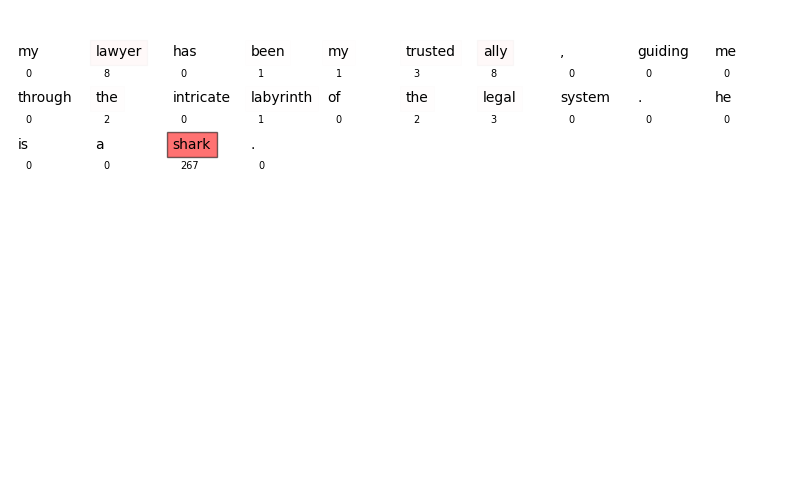

In [93]:
highlight_text(masked_sentences, lamb=0.003)

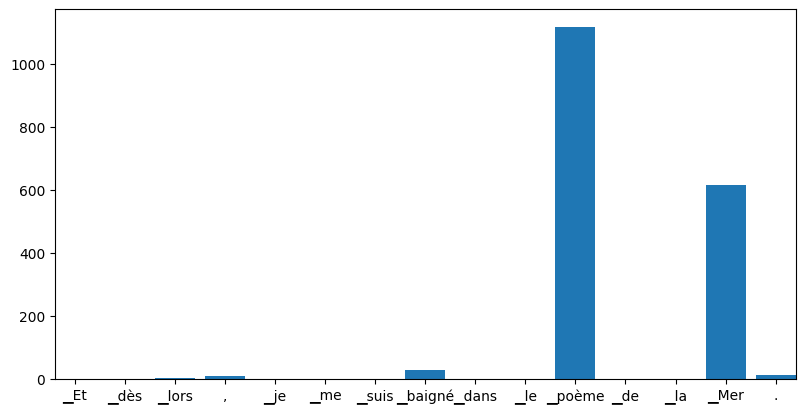

In [9]:
plot_barSurprise(masked_sentences)

# //

# <>